This is the original notebook used to create my data set and experiment with training. For the notebook used to create the final model exported to the webpage, look at the 'Fruits Good.ipynb' file.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [72]:
folder = 'Apple'
file = 'urls_apple.csv'

In [75]:
folder = 'Banana'
file = 'urls_banana.csv'

In [78]:
folder = 'Blackberry'
file = 'urls_blackberry.csv'

In [81]:
folder = 'Blueberry'
file = 'urls_blueberry.csv'

In [88]:
folder = 'Lemon'
file = 'urls_lemon.csv'

In [91]:
folder = 'Lime'
file = 'urls_lime.csv'

In [94]:
folder = 'Mango'
file = 'urls_mango.csv'

In [97]:
folder = 'Orange'
file = 'urls_orange.csv'

In [100]:
folder = 'Pear'
file = 'urls_pear.csv'

In [103]:
folder = 'Raspberry'
file = 'urls_raspberry.csv'

In [106]:
folder = 'Strawberry'
file = 'urls_strawberry.csv'

In [109]:
folder = 'Tomato'
file = 'urls_tomato.csv'

In [5]:
path = Path('data/Fruit')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

NameError: name 'folder' is not defined

In [27]:
path.ls()

[PosixPath('data/Fruit/Lime'),
 PosixPath('data/Fruit/Pear'),
 PosixPath('data/Fruit/Lemon'),
 PosixPath('data/Fruit/Apple'),
 PosixPath('data/Fruit/Strawberry'),
 PosixPath('data/Fruit/Blueberry'),
 PosixPath('data/Fruit/Banana'),
 PosixPath('data/Fruit/Orange'),
 PosixPath('data/Fruit/Blackberry'),
 PosixPath('data/Fruit/Raspberry'),
 PosixPath('data/Fruit/Tomato'),
 PosixPath('data/Fruit/Mango')]

In [59]:
classes = ['Apple', 'Banana', 'Blackberry', 'Blueberry', 'Lemon', 'Lime', 'Mango', 'Orange', 
          'Pear', 'Raspberry', 'Strawberry', 'Tomato']

To download the images from Google images, I used a script shown in the fast.ai course. The script saves the urls for the all loaded images locally. I then uploaded them to the appropriate directory and then used their function to extract the images from the saved urls for each category. Here is the script:

urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [111]:
download_images(path/file, dest, max_pics=300)

In [112]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

Apple


Banana


Blackberry


Blueberry


Lemon


Lime


Mango


Orange


Pear


Raspberry


Strawberry


Tomato


Now it's time to create a data bunch, which is what fast.ai calls their data sets. The parameter 'valid_pct' is the percentage of the images in my dataset which will act as the validation set. In this case, I used an 80/20 split for training/validation sets.

In [113]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [114]:
data.classes

['Apple',
 'Banana',
 'Blackberry',
 'Blueberry',
 'Lemon',
 'Lime',
 'Mango',
 'Orange',
 'Pear',
 'Raspberry',
 'Strawberry',
 'Tomato']

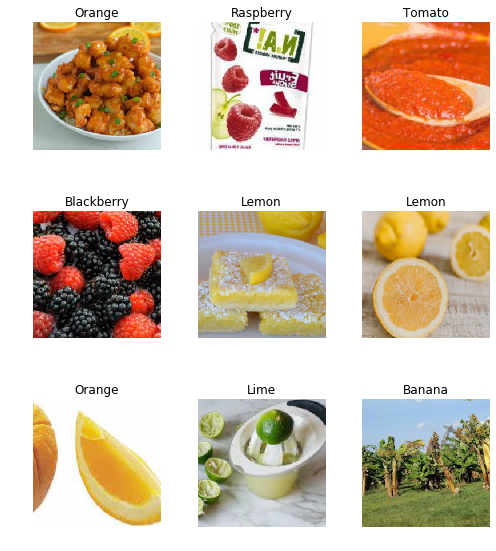

In [115]:
data.show_batch(rows=3, figsize=(7,8))

In [116]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Apple',
  'Banana',
  'Blackberry',
  'Blueberry',
  'Lemon',
  'Lime',
  'Mango',
  'Orange',
  'Pear',
  'Raspberry',
  'Strawberry',
  'Tomato'],
 12,
 2880,
 720)

I initially attempted to train using the ResNet34 framework.

In [117]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [118]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.150268,0.867957,0.252778,00:12
1,1.354227,0.745525,0.229167,00:10
2,0.992234,0.685550,0.212500,00:10
3,0.782158,0.666844,0.215278,00:10


In [119]:
learn.save('stage-1')

The unfreeze() function essentially allows the rest of the layers in the model to be trained. Without unfreezing, the fast.ai library only trains the a certain amount of layers.

In [121]:
learn.unfreeze()

In [122]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


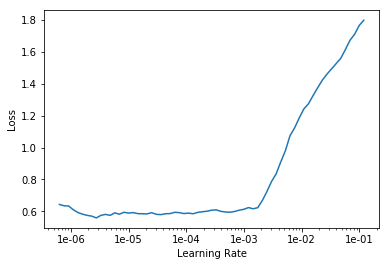

In [123]:
learn.recorder.plot()

In [124]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.615737,0.635684,0.208333,00:13
1,0.557599,0.633611,0.208333,00:12


In [125]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2')

In [128]:
interp = ClassificationInterpretation.from_learner(learn)

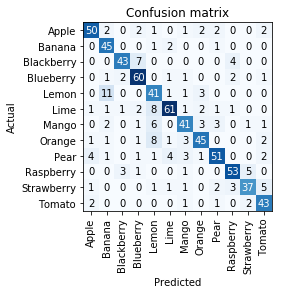

In [129]:
interp.plot_confusion_matrix()

As you can see below, some of the error has come from incorrectly labeled images or images that aren't actually one of the fruits, so the model is probably doing better than it says.

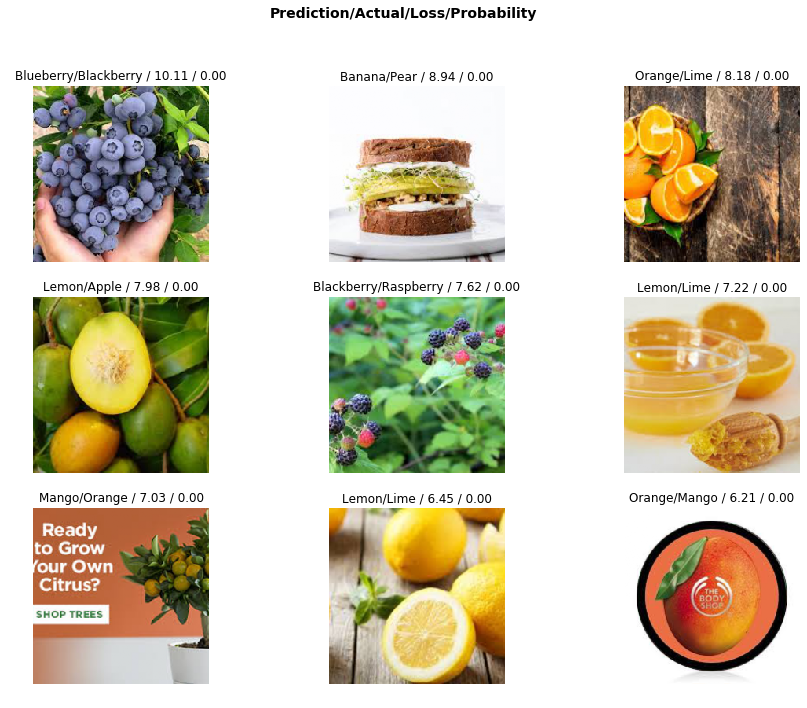

In [130]:
interp.plot_top_losses(9, figsize=(15,11))

The ImageCleaner widget created by fast.ai is what I used to clean the dataset. The widget will not show unless I'm in the process of cleaning, but it easily allows me to delete or rename images, or leave them as is. 

In [131]:
from fastai.widgets import *

In [132]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [134]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [135]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [136]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [145]:
np.random.seed(42)
data1 = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                                ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

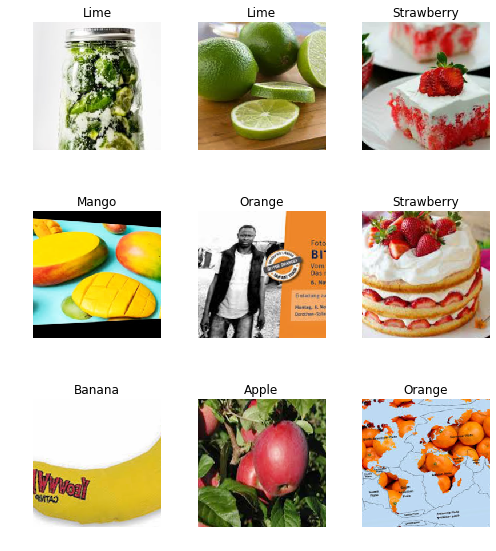

In [147]:
data1.show_batch(rows=3, figsize=(7,8))

In [148]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Apple',
  'Banana',
  'Blackberry',
  'Blueberry',
  'Lemon',
  'Lime',
  'Mango',
  'Orange',
  'Pear',
  'Raspberry',
  'Strawberry',
  'Tomato'],
 12,
 2381,
 595)

In [149]:
learn1 = cnn_learner(data1, models.resnet34, metrics=error_rate)

In [150]:
learn1.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.042961,0.657599,0.220168,00:10
1,1.132199,0.535892,0.173109,00:08
2,0.750314,0.489619,0.173109,00:09
3,0.541236,0.467541,0.164706,00:08


In [151]:
learn1.save('stage-1')

In [152]:
learn1.unfreeze()

In [153]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


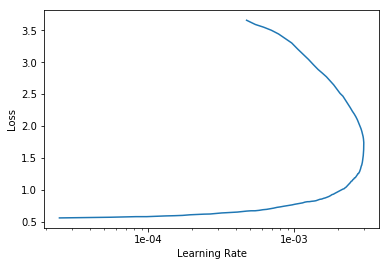

In [154]:
learn1.recorder.plot()

In [156]:
learn1.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.393465,0.480665,0.151261,00:10
1,0.290949,0.391922,0.121008,00:11


In [157]:
learn1.save('stage-2')

In [158]:
learn1.load('stage-2');

In [159]:
interp1 = ClassificationInterpretation.from_learner(learn)

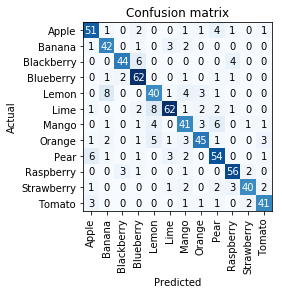

In [161]:
interp1.plot_confusion_matrix()

In [162]:
learn1.save('stage-2')

In [163]:
learn1.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.209053,0.372974,0.117647,00:11
1,0.166397,0.347470,0.107563,00:10


In [164]:
learn1.save('stage-3')

In [165]:
learn1.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.149149,0.372434,0.109244,00:11
1,0.145071,0.358993,0.105882,00:11


In [ ]:
learn1.load('stage-3')

In [167]:
 db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

In [168]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-3');

In [169]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [170]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [ ]:
path = Path('data/Fruit')

In [6]:
np.random.seed(42)
data2 = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                                ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

I trained the model again with the exact same training and validation sets with ResNet34, now starting with a mostly cleaned dataset.

In [8]:
learn2 = cnn_learner(data2, models.resnet34, metrics=error_rate)

In [10]:
learn2.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.085486,0.610509,0.182292,00:11
1,1.158008,0.520208,0.145833,00:09
2,0.754807,0.470500,0.133681,00:08
3,0.559979,0.456820,0.131944,00:08


In [11]:
learn2.unfreeze()

In [13]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


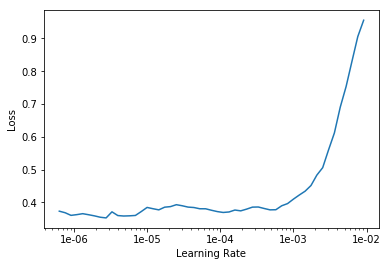

In [14]:
learn2.recorder.plot()

In [15]:
learn2.fit_one_cycle(2, max_lr=slice(3e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.374082,0.448194,0.126736,00:11
1,0.355220,0.442917,0.119792,00:10


In [16]:
learn2.fit_one_cycle(2, max_lr=slice(6e-4,8e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.442733,82.466980,0.859375,00:10
1,1.161176,0.745775,0.234375,00:10


I then decided to try training with ResNet50 it to try and get better results. This is with the already cleaned data set.

In [17]:
learn3 = cnn_learner(data2, models.resnet50, metrics=error_rate)

In [18]:
learn3.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.513528,0.641567,0.177083,00:16
1,0.885410,0.553598,0.152778,00:15
2,0.593665,0.444653,0.126736,00:15
3,0.408127,0.424852,0.121528,00:15


In [19]:
learn3.save('stage-1-3')

In [20]:
learn3.unfreeze()

In [21]:
learn3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


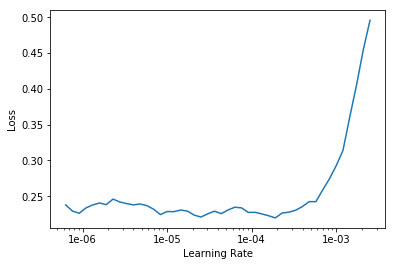

In [22]:
learn3.recorder.plot()

In [23]:
learn3.fit_one_cycle(3, max_lr=slice(6e-5,6e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.341596,0.588369,0.163194,00:20
1,0.367999,0.471229,0.128472,00:20
2,0.255048,0.360423,0.107639,00:20


In [24]:
learn3.save('stage-2-3')

In [25]:
learn3.fit_one_cycle(1, max_lr=slice(6e-5,6e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.123502,0.376749,0.097222,00:20


In [26]:
learn3.save('stage-3-3')

In [ ]:
learn3.load('stage-3-3')